In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import probplot

from electronfactors import (
    create_model, pull_data, fit_give, estimate_population_uncertainty,
    create_green_cm
)

In [2]:
run_full_calculation = False  # True

In [3]:
green_cm = create_green_cm()

def colour(x, alpha=1):
    result = list(green_cm(x))
    result[3] = alpha
    
    return result

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})
# rc('text', usetex=True)

In [5]:
# width, length, eqPonA, factor = pull_data(energy=12)

with open("model_cache/12MeV_10app_100ssd.yml", 'r') as file:
    cutout_data = yaml.load(file)
    
label = np.array([key for key in cutout_data])
book_factor = np.array([item[0] == 'P' for i, item in enumerate(label)])

custom_label = label[~book_factor]

width = np.array([cutout_data[key]['width'] for key in custom_label])
length = np.array([cutout_data[key]['length'] for key in custom_label])
factor = np.array([cutout_data[key]['factor'] for key in custom_label])

perimeter = np.pi / 2 * (3*(width + length) - np.sqrt((3*width + length)*(3*length + width)))
area = np.pi / 4 * width * length
eqPonA = perimeter / area

In [6]:
store = np.array([])
mean_diff = np.array([])
individual_std = np.array([])

In [7]:
amount = 8
if run_full_calculation:
    n = 100000
else:
    n = 100

    
for j in range(n):
    order = np.arange(len(width))
    np.random.shuffle(order)
    reference = order[0:amount]
    reference
    check = np.setdiff1d(np.arange(len(width)), reference)
    check
    give = np.zeros(len(check))
    predictions = np.zeros(len(check))

    model = create_model(width[reference], eqPonA[reference], factor[reference])

    for i, value in enumerate(check):
        predictions[i] = model(width[value], eqPonA[value])
        give[i] = fit_give(
            width[value], eqPonA[value], 
            width[reference], eqPonA[reference], factor[reference])

    percent_prediction_differences = 100*(factor[check] - predictions) / factor[check]

    valid = give < 0.5
    store = np.append(store, percent_prediction_differences[valid])
    mean_diff = np.append(mean_diff, np.mean(percent_prediction_differences[valid]))
    individual_std = np.append(individual_std, np.std(percent_prediction_differences[valid]))

Mean = -0.02
Uncertainty = 0.47


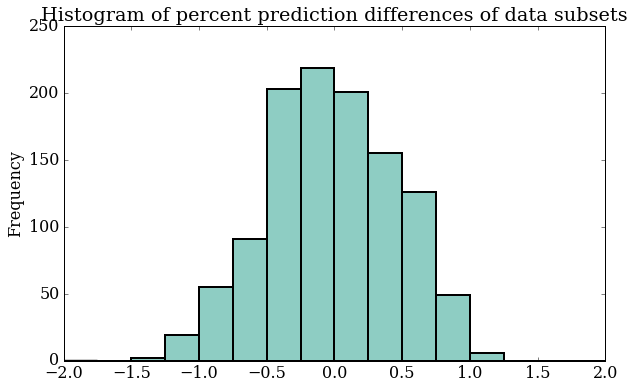

In [8]:
bins = np.arange(-2, 2.25, 0.25)

plt.figure(figsize=(6 * 1.618, 6))

plt.hist(store, bins, lw=2, fc=colour(0.55, alpha=0.5))

uncertainty = estimate_population_uncertainty(store)

print("Mean = %0.2f" % (np.mean(store)))
print("Uncertainty = %0.2f" % (uncertainty))

# plt.xlabel(
#     r'\% Prediction Difference '
#     r'$\left[100 \times \frac{\mbox{measured } - \mbox{ predicted}}{\mbox{measured}} \right]$')
plt.ylabel(r'Frequency')
plt.title(r'Histogram of percent prediction differences of data subsets')

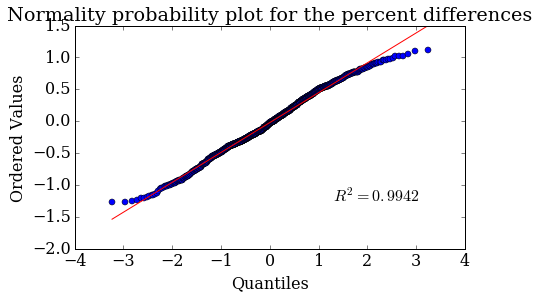

In [9]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

probplot(store, plot=ax);

ax.set_title("Normality probability plot for the percent differences")

In [10]:
np.min(store)

-1.2726854303727082

In [11]:
np.max(store)

1.1146105382831661

In [12]:
len(store)

1126